# Importing the Libraries
lets import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset

In [2]:
dataset = pd.read_csv('train.csv')

# Exploratory Data Analysis (EDA) and Data preprocessing
lets start exploring our dataset!

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- we have **1460** rows of data
- we have **81** features, Out of which we have **ID** and  **SalePrice** - Our target variable
- We have **44 Categorical Variables** and **35 Numerical Features**

<Axes: >

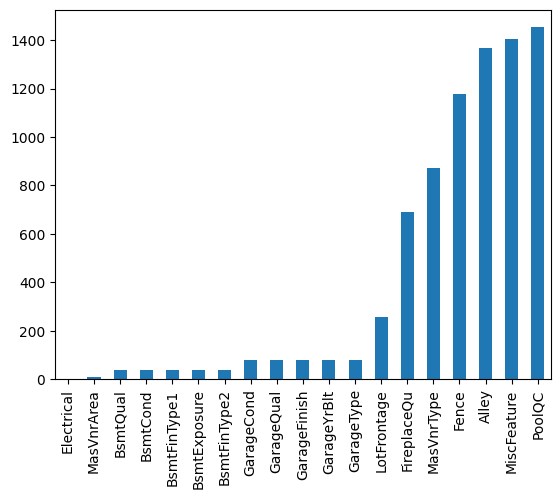

In [4]:
missing = dataset.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

- we have **19** Features with missing values

In [5]:
y = dataset['SalePrice']
X = dataset.drop(columns=['Id', 'SalePrice'])

**Numerical** and **Categorical** features

In [6]:
categorical_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 
                        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
                        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
                        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 
                        'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                        'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                        'SaleType', 'SaleCondition']

numerical_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
                      'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                      'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 
                      'MoSold', 'YrSold']

# Handling Missing values

**Handling missing values**

In [7]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X[numerical_features] = imputer.fit_transform(X[numerical_features])

In [8]:
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer.fit(X[categorical_features])
X[categorical_features] = cat_imputer.transform(X[categorical_features])

# Encoding the Categorical Variables

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
X = ct.fit_transform(X).toarray()

## Splitting the dataset into the Training set and Test set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Training a XGBoost Model on the training data

In [12]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(np.log(y_test), np.log(y_pred))
rmse = np.sqrt(mse)
print("RMSE:", rmse)

from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

RMSE: 0.14736092731585926
R2: 0.9082424640655518


# lets perform Hyperparameter Tuning

we will use  **RandomizedSearch**

In [13]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

best_regressor = random_search.best_estimator_
y_pred = best_regressor.predict(X_test)

mse = mean_squared_error(np.log(y_test), np.log(y_pred))
rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, y_pred)
print("R2:", r2)

RMSE: 0.13492308125337912
R2: 0.9226478338241577


# Lets make submission

In [14]:
test_dataset = pd.read_csv('test.csv')
test_X = test_dataset.drop(columns=['Id'])
test_X[numerical_features] = imputer.transform(test_X[numerical_features])
test_X[categorical_features] = cat_imputer.transform(test_X[categorical_features])
test_X = ct.transform(test_X).toarray()
test_X = sc.transform(test_X)

test_y = best_regressor.predict(test_X)

submission = pd.DataFrame({'Id': test_dataset['Id'], 'SalePrice': test_y})
submission.to_csv('submission.csv', index=False)